#### Marcelo Mandirola
## Reinforcement Learning Tarea 1 - K Armed Bandits

### Objetivos:
Demostrar entendimiento sobre K-Armed Bandits, implementar varios algoritmos vistos en el curso teórico y comparar su performance en un mismo problema (ambiente).

### A entregar:
- Implementación de agente arbitrario.
- Implementación de agente epsilon-greedy.
- Implementación de agente epsilon-greedy optimista.
- Implementación de agente upper confidence bound.
- Grafique la evolución de las recompensas (reward) a lo largo del tiempo para cada algoritmo, promediado sobre 2000 ejecuciones.
- Escriba un reporte sobre sus implementaciones comparando los distintos agentes implementados.

### Instalación y carga de ambiente

`git clone https://github.com/JKCooper2/gym-bandits.git`

`cd gym-bandits`

`pip install .`

In [1]:
# Para usarlo desde Google Colab
!git clone https://github.com/JKCooper2/gym-bandits.git
!cd gym-bandits
!pip install gym-bandits/

fatal: destination path 'gym-bandits' already exists and is not an empty directory.
Processing ./gym-bandits
  Created wheel for gym-bandits: filename=gym_bandits-0.0.2-py3-none-any.whl size=5178 sha256=9ad9d905c40bae1c35dbeeab685dfd817e4c4af87085c17e9e7297795e3a676c
  Stored in directory: /home/marcelo/.cache/pip/wheels/0e/e6/15/4b5dcfa4b8658ad243e1d1af4808b8b80d816faaeba4b64c9a
Successfully built gym-bandits
  Attempting uninstall: gym-bandits
    Found existing installation: gym-bandits 0.0.2
    Uninstalling gym-bandits-0.0.2:
      Successfully uninstalled gym-bandits-0.0.2


## Descripción del ambiente a usar

Vamos a usar GymBandits, una libreria diseñada para ser utilizada sobre OpenAi Gym (https://gym.openai.com/) pero orientada a Armed Bandits. 

Recordando el teórico, sabemos que un K Armed Bandit representa una maquina tragamonedas con multiples brazos (K) y donde nuestra recompensa depende de cual brazo tiremos.

En este caso particular, `BanditTenArmedGaussian` es el ambiente a utilizar (página 30 del libro de Sutton y Barto), cuenta con 10 brazos (K=10) y por cada interaccion con el ambiente (`step`) nustra recompensa (reward) depende de que brazo elegimos entre los 10 posibles. En este ambiente, todos los brazos tienen una recompensa (que puede ser negativa en algunos casos) y nuestro objetivo es diseñar agentes que maximicen la suma total de recompensas a lo largo de 1000 interacciones con el ambiente (`1000 steps`).

## Definicion del ambiente e imports necesarios

In [2]:
import gym
import random
import gym_bandits
import numpy as np
import matplotlib.pyplot as plt

def get_env():
    return gym.make("BanditTenArmedGaussian-v0")    

In [3]:
sample_env = get_env()
sample_env.action_space

Discrete(10)

In [4]:
number_steps = 1000

In [5]:
from Agent import Agent

### Implementación de agente arbitrario

In [6]:
class RandomAgent(Agent):
    def __init__(self, name):
        super().__init__(name)        

    def reset_internal_state(self):
        pass

    def select_action(self, game_state):
        return random.randrange(0, self.environment.action_space.n)

    def update_internal_state(self, observation, action, reward):
        pass
    
    def get_extra_info(self):
        return None

# Example run
random_agent = RandomAgent("RandomAgent")

logs, info = random_agent.play(n_steps = 1000, environment =sample_env)

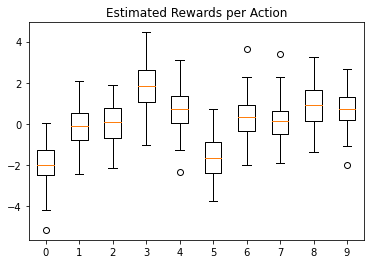

In [7]:
data = list(map(lambda x: np.array(x), logs['actions_rewards'].values()))
labels = list(logs['actions_rewards'].keys())
fig1, ax1 = plt.subplots()
ax1.set_title('Estimated Rewards per Action')
a = ax1.boxplot(data, labels = labels)

In [8]:
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

Accumulated reward: 101.13
Mean reward: 0.10


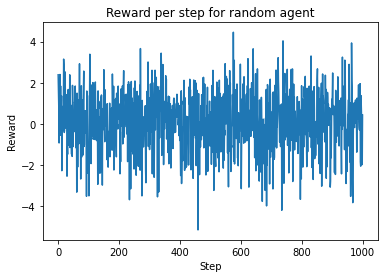

In [9]:
# Example plot
plt.plot(range(number_steps), logs['rewards'])
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward per step for random agent")
plt.show()

### Implementación de agente epsilon-greedy

In [10]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon):
        super().__init__(name)
        self.epsilon = epsilon

    def reset_internal_state(self):
        self.q_a = np.zeros(self.environment.action_space.n)
        self.n_a = np.zeros(self.environment.action_space.n)

    def select_action(self, game_state):
        probability = random.uniform(0,1)
        if probability < self.epsilon:
            action = random.randrange(0, self.environment.action_space.n)
        else:
            indices = np.where(self.q_a == np.amax(self.q_a))[0]
            action = indices[random.randrange(0, len(indices))]
        return action
   
    def update_internal_state(self, observation, action, reward):
        self.n_a[action] += 1
        self.q_a[action] = self.q_a[action] + (reward - self.q_a[action]) / self.n_a[action]

    
    def get_extra_info(self):
        return {
            'q_a': self.q_a,
            'n_a': self.n_a
        }

# Example run
epsilon_greedy_agent = EpsilonGreedyAgent("EpsilonGreedyAgent", 0.3)

logs, info = epsilon_greedy_agent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[ 25.  31.  37. 719.  31.  30.  21.  33.  37.  36.]
[-1.63739528 -0.27893523  0.23463257  2.06414963  0.76878497 -1.58288481
  0.19235289  0.44369511  1.00947609  0.51281511]
Accumulated reward: 1494.06
Mean reward: 1.49


### Implementación de agente epsilon-greedy optimista

In [11]:
class OptimisticEpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon, q_1):
        super().__init__(name)
        self.epsilon = epsilon
        self.q_1 = q_1

    def reset_internal_state(self):
        self.q_a = np.ones(self.environment.action_space.n) * self.q_1
        self.n_a = np.zeros(self.environment.action_space.n)
    
    def select_action(self, game_state):
        probability = random.uniform(0,1)
        if probability < self.epsilon:
            action = random.randrange(0, self.environment.action_space.n)
        else:
            indices = np.where(self.q_a == np.amax(self.q_a))[0]
            action = indices[random.randrange(0, len(indices))]
        return action   
    def update_internal_state(self, observation, action, reward):
        self.n_a[action] += 1
        self.q_a[action] = self.q_a[action] + (reward - self.q_a[action]) / self.n_a[action]    
    def get_extra_info(self):
        return {
            'q_a': self.q_a,
            'n_a': self.n_a
        }

# Example run
optimistic_epsilon_greedy_agent = OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent", 0.3, q_1 = 10)

logs, info = optimistic_epsilon_greedy_agent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[ 44.  26.  29. 718.  32.  40.  35.  27.  25.  24.]
[-1.87786825 -0.15806153  0.36726835  1.9797059   0.73060162 -1.86509733
  0.25838129  0.07578918  1.28374819  0.33363646]
Accumulated reward: 1345.31
Mean reward: 1.35


### Implementación de agente upper confidence bound

In [12]:
class UCBAgent(Agent):
    def __init__(self, name, C):
        super().__init__(name)
        self.c = C
        self.t = 1
        

    def reset_internal_state(self):
        self.q_a = np.zeros(self.environment.action_space.n)
        self.n_a = np.ones(self.environment.action_space.n)
    def select_action(self, game_state):
        import math
        bounds = [
            self.q_a[i] + self.c * math.sqrt((math.log(self.t) / self.n_a[i]))
            for i in range(0, self.environment.action_space.n)
        ]
        indices = np.where(bounds == np.amax(bounds))[0]
        action = indices[random.randrange(0, len(indices))]
        return action
   
    def update_internal_state(self, observation, action, reward):
        self.t += 1
        self.q_a[action] = self.q_a[action] + (reward - self.q_a[action]) / self.n_a[action]    
        self.n_a[action] += 1
    
    def get_extra_info(self):
        return {
            'q_a': self.q_a,
            'n_a': self.n_a
        }


# Example run
UCB_agent = UCBAgent("UCBAgent", 1)

logs, info = UCB_agent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[  2.   3.   2. 978.   5.   2.   2.   2.  12.   2.]
[-2.61109517  0.04049741  0.02869242  1.99680186  0.76660482 -1.79299243
 -0.36670553  0.1439362   1.00377954 -0.46157571]
Accumulated reward: 1960.00
Mean reward: 1.96


### Reporte

In [13]:
def calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, agent_constructor, param):
    many_rewards = []
    many_selected_best_action = []
    for i in range(n_runs):
        env = get_env()
        agent = agent_constructor(param)
        logs, info = agent.play(n_steps, env)
        many_rewards.append(logs['rewards'])
        many_selected_best_action.append(logs['selected_best_action'])
    mean_rewards = np.mean(many_rewards, axis = 0)
    mean_selected_best_action = np.mean(many_selected_best_action, axis = 0)    
    return {"mean_rewards": mean_rewards, "mean_selected_best_action":mean_selected_best_action}

In [14]:
from functools import partial 

parameters_eps_greedy = [0, 0.1, 0.01]

#Para epsilon greedy optimista con tasa de actualización no fija con que Q0 esté sobre la media basta (default 10 = OK)
parameters_eps_greedy_opt = [0, 0.1, 0.01]


parameters_ucb = [0.25, 0.5, 1, 2, 4]

n_runs = 2000
n_steps = 1000

eps_greedy_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(EpsilonGreedyAgent, "EpsilonGreedyAgent"),x)), parameters_eps_greedy))

eps_greedy_opt_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(OptimisticEpsilonGreedyAgent, "EpsilonGreedyAgent", q_1 = 10)  ,x)), parameters_eps_greedy_opt))

ucb_results = list(map(lambda x: (x,calculate_mean_rewards_and_selected_optimal_action_by_step(n_runs, n_steps, partial(UCBAgent, "UCBAgent"),x)), parameters_ucb))

In [15]:
def plot_results(results, param_name, metric, plot_title, x_label, y_label, n_steps):
    plt.figure(figsize=(10,5))
    for param, means in results:
        plt.plot(range(n_steps), means[metric], label=param_name+' = '+str(param))        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend()
    plt.show()

#### Epsilon Greedy:

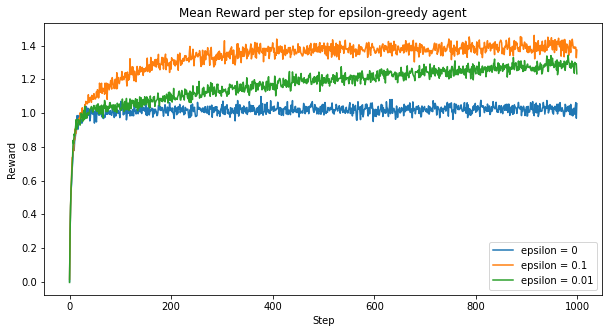

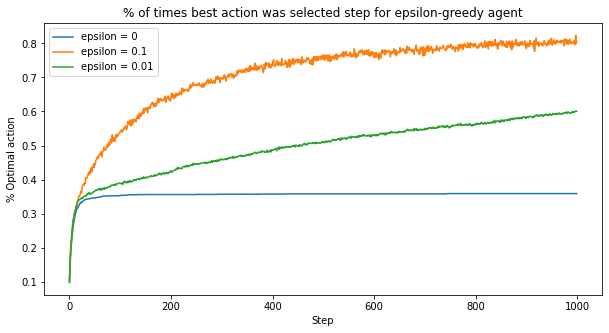

In [16]:
plot_results(eps_greedy_results, "epsilon","mean_rewards","Mean Reward per step for epsilon-greedy agent","Step","Reward", n_steps)
plot_results(eps_greedy_results, "epsilon","mean_selected_best_action","% of times best action was selected step for epsilon-greedy agent","Step","% Optimal action", n_steps)

#### Comentarios:
El agente con épsilon = 0 actúa como un agente greedy puro y cuando encuentra una recompensa mayor que 0, que es el valor en el cúal iniciamos nuestro q(A), lo explota sin explorar las otras máquinas, por lo tanto se pierde de descubrir una mejor opción quedando atrapado en un máximo local y llegando a un resultado subóptimo
El agente con épsilon = 0.01 descubre mejores opciones porque realiza una exploración aleatoria el 1% de la veces, lo cual le da la posibilidad de seguir explorando despues de encontrar una buena recompensa, pero si lo comparamos con el agente 0.1 explora muy poco, ya que este ultimo agente encuentra la mejor acción más rápido
El agente con épsilon = 0.1 es el mejor para este caso y esta cota de tiempo, explora una mayor cantidad de veces lo cual le permite encontrar la mejor acción mas rápido y por lo tanto explotarla mas seguido.
Para este experimento el parámetro épsilon = 0.1 sería el mejor de todos, pero si el ambiente cambiase por ejemplo si aumentásemos la cantidad de pasos del experimento la penalización a la explotación que estamos asumiendo en pro de encontrar la acción mejor mas rápido, empezaría a pesar más dado que a medida que el tiempo transcurre, como las máquinas no tienen estado, las medias empezarían a converger y no sería nescesario explorar tanto, haciendo que el agente 0.01 supere al 0.1

#### Epsilon Greedy Optimista:

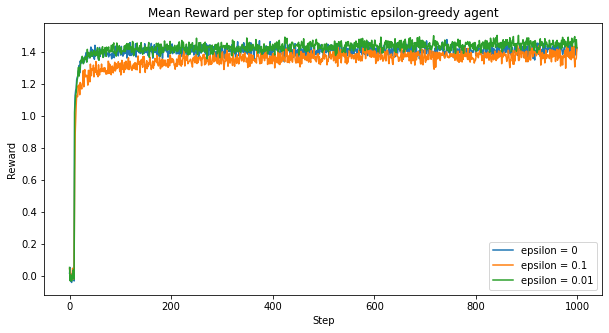

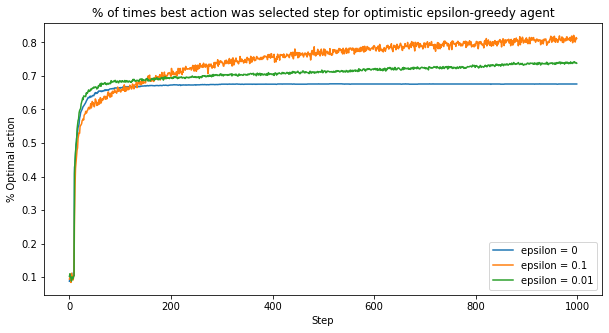

In [17]:
plot_results(eps_greedy_opt_results, "epsilon","mean_rewards","Mean Reward per step for optimistic epsilon-greedy agent","Step","Reward", n_steps)
plot_results(eps_greedy_opt_results, "epsilon","mean_selected_best_action","% of times best action was selected step for optimistic epsilon-greedy agent","Step","% Optimal action", n_steps)

#### Comentarios:
Al principio el agente épsilon optimista se comporta como un agente arbitrario hasta que explora todas las acciones posibles, eso explica la irregularidad de las gráficas inicialmente.
De la exploración de todas las acciones inicial se encuentra un mejor punto de partida que con el épsilon-greedy no optimista, si comparamos el épsilon = 0 de los épsilon-greedy optimista y no optimista de las gráficas de % de veces que se seleccionó la accion óptima, se nota una mejoría del épsilon-greedy optimista.
Si se mira la gráfica el agente 0.1 es menos performante hasta el instante de tiempo 200 aprox, esto se debe a que la estimación inicial es bastante buena y  el agente con épsilon = 0.1 del épsilon-greedy optimista tiene que explorar más tiempo para contrarestar la penalización que le estamos dando a la explotación, luego del instante 200 el agente 0.1 consigue una mejor recompensa saliendo del máximo relativo y siendo el mejor valor de epsilon para este caso

#### UCB

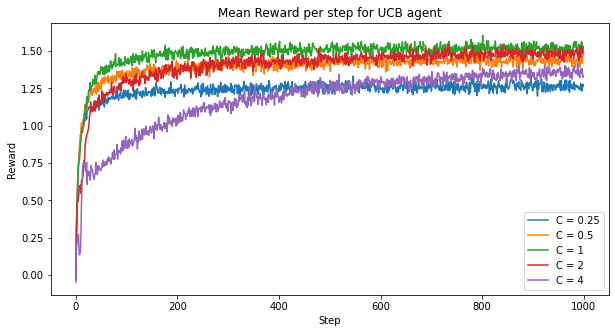

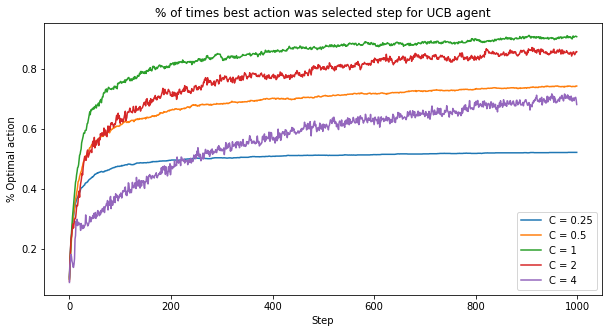

In [18]:
plot_results(ucb_results, "C","mean_rewards","Mean Reward per step for UCB agent","Step","Reward", n_steps)
plot_results(ucb_results, "C","mean_selected_best_action","% of times best action was selected step for UCB agent","Step","% Optimal action", n_steps)

#### Comentarios:

Los agentes con c=0.25 y c=4, ponderan muy bajo y muy alto el término del upper confidence bound por lo tanto exploran poco y penalizan demasiado la explotación con demasiada exploración respectivamente.
Con respecto a los agentes c=0.5, c=1 y c=2, el agente con c=1 es el mejor no por demasiado márgen, dado un caso en particular el modo de obtener un c óptimo seria experimentalmente ya que depende de los valores de las recompensas y del instante de tiempo máximo.
Al principio de la gráfica la irregularidad se debe a que, como todavia no se jugaron suficientes palancas, el logaritmo del instante t del término upper confidence bound es más grande haciendo que se explore aleatoriamente más al principio.


#### A continuación compararemos los que mejor resultado dan en una misma gráfica

In [19]:
eps_greedy_results_means = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), eps_greedy_results))
eps_greedy_opt_results_means = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), eps_greedy_opt_results))
ucb_results_means  = list(map(lambda x: (x[0], x[1],np.mean(x[1]['mean_rewards'])), ucb_results))

In [20]:
best_eps_greedy = max(eps_greedy_results_means,key=lambda item:item[2])
best_eps_greedy_opt = max(eps_greedy_opt_results_means,key=lambda item:item[2])
best_ucb = max(ucb_results_means,key=lambda item:item[2])

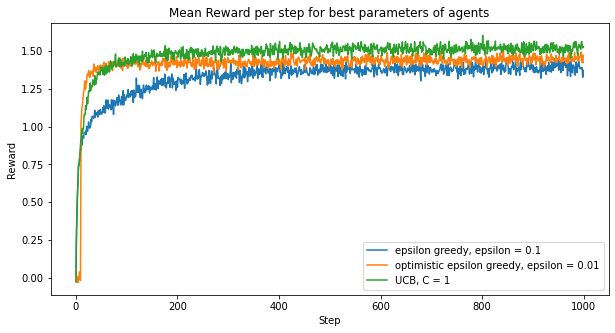

In [21]:
plt.figure(figsize=(10,5))    
plt.plot(range(n_steps), best_eps_greedy[1]['mean_rewards'], label='epsilon greedy, epsilon = '+str(best_eps_greedy[0]))
plt.plot(range(n_steps), best_eps_greedy_opt[1]['mean_rewards'], label='optimistic epsilon greedy, epsilon = '+str(best_eps_greedy_opt[0]))
plt.plot(range(n_steps), best_ucb[1]['mean_rewards'], label='UCB, C = '+str(best_ucb[0]))
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Mean Reward per step for best parameters of agents")
plt.legend()
plt.show()

#### Comentarios:

Todos los agentes aprenden dado que la esperanza media aumenta a medida que transcurren los instantes de tiempo.
Salvo los primeros instantes, el agente épsilon-greedy empieza de peor manera dado que no explora todas las acciones y probablemente estuviese atrapado en un máximo local hasta que se explore lo suficiente y empiece a converger con el épsilon greedy optimista.
El que performa mejor dado el problema como en la clase teórica es el UCB, dado que explora más al principo cuando es requerido, cuando se necesita más información cuando el t es mas chico y explora menos cuando no es necesario cuando las medias empiezan a converger, el t es mas grande y la exploración empieza a ser una penalización.
